## Austin BCycles Regression Analysis

In [16]:
import pandas as pd
import numpy as np
import requests 
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import ResidualsPlot

trips = pd.read_csv('clean_trips.csv')

# Weather Underground API to extract relevant weather data

# Extract the relevant dates in the proper format from trips df

# if in datetime format
#dates = trips['checkout_date'].sort_values().apply(lambda x: x.strftime("%Y%m%d")).unique()

# if in string format
dates = pd.to_datetime(trips['checkout_date'], format='%Y-%m-%d').sort_values().apply(lambda x: x.strftime("%Y%m%d")).unique()

daily_temp = []
daily_feels_like = []
daily_wind_spd = []
daily_precip = []

# API request for weather info on relevant dates
for d in dates:
    url = "https://api.weather.com/v1/location/KAUS:9:US/observations/historical.json?apiKey=6532d6454b8aa370768e63d6ba5a832e&units=e&startDate={}&endDate={}".format(d, d)
    
    # API request
    r = requests.get(url)
    weather_json = r.json()

    temps = []
    wind = []
    feels_like = []
    precip = []

    # Extract raw data
    # Replace any NA values with the previous value reported
    for obs in weather_json['observations']:
        temps.append(obs['temp']) if obs['temp'] is not None else temps[-1]
        wind.append(obs['wspd']) if obs['wspd'] is not None else wind[-1]
        feels_like.append(obs['feels_like']) if obs['feels_like'] is not None else feels_like[-1]
        precip.append(obs['precip_hrly']) if obs['precip_hrly'] is not None else precip[-1]
       

    # Get daily averages
    daily_temp.append(round(np.mean(temps), 0))
    daily_feels_like.append(round(np.mean(feels_like), 0))
    daily_wind_spd.append(round(np.mean(wind), 0))
    daily_precip.append(round(sum(precip), 1))

In [17]:
# Create weather data frame

# Group trip by date, just looking for total trips, not distance
daily_trip_count = trips.groupby('checkout_date')['trip_minutes'].count()


weather_df = pd.DataFrame({'date': daily_trip_count.index,
                          'temp_F': daily_temp,
                          'feels_like_F': daily_feels_like,
                          'wind_mph': daily_wind_spd,
                          'rain': daily_precip,
                          'total_trips': daily_trip_count.values})



In [18]:
# convert date to datetime
weather_df['date'] = pd.to_datetime(weather_df['date'], format = '%Y-%m-%d')

# code day of the week and month using datetime, important to capture seasonality trends
weather_df['day_of_week'] = weather_df['date'].dt.weekday.map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday',5:'Saturday', 6:'Sunday'})
weather_df['month'] = weather_df['date'].dt.month.map({1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"})

# Dummy code variables to capture categorical data
weather_df = pd.get_dummies(weather_df, columns=['day_of_week'])
weather_df = pd.get_dummies(weather_df, columns=['month'])

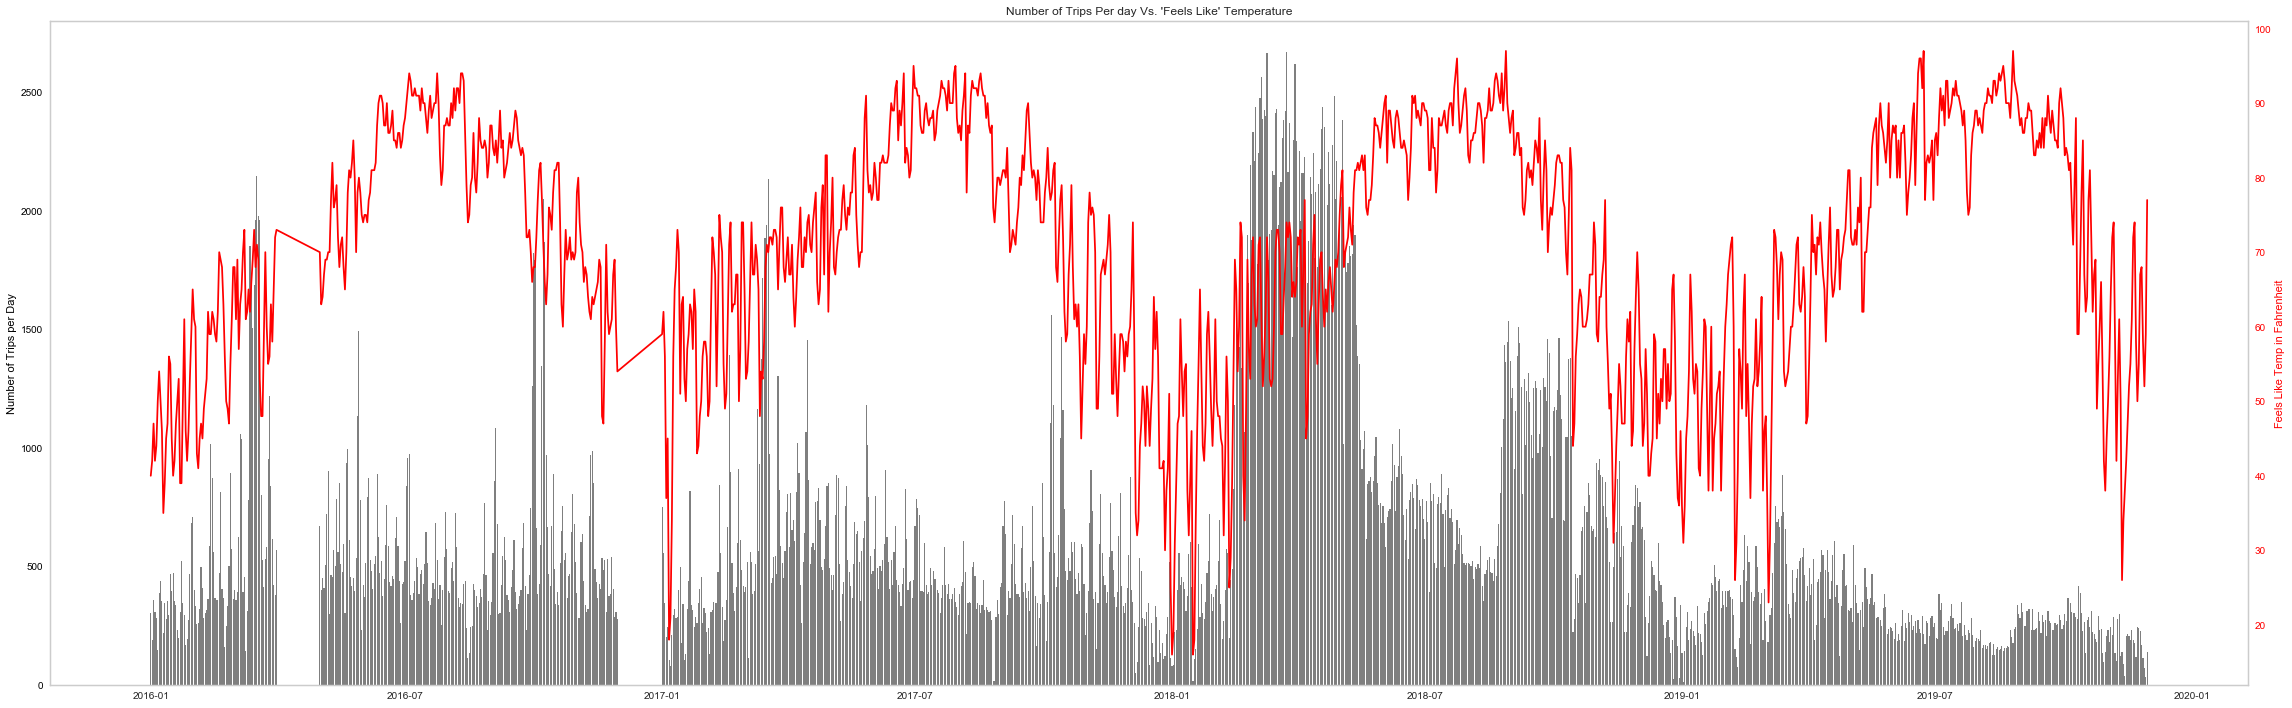

In [19]:
# Plot number of trips per day vs feels like temperature
fig, ax1 = plt.subplots(figsize=(32,10))


plt.title("Number of Trips Per day Vs. 'Feels Like' Temperature")
ax1.set_xlabel("")
ax1.set_ylabel('Number of Trips per Day', color='black')
ax1.bar(weather_df['date'], weather_df['total_trips'], color='black', alpha=.5)
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(False)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Feels Like Temp in Fahrenheit', color='red')  # we already handled the x-label with ax1
ax2.plot(weather_df['date'], weather_df['feels_like_F'], color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.grid(False)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Here we see the relationship between the 'feels like' temperature (adjusted for heat index and wind chill) and daily number of trips. We see a pattern of high bike use when the temperature is moderate (60F-80F) and less use in more extreme temperature ranges.

We have incorporated weather and month/day of the week into our model. Let's look for more descriptive data that can help our predictive power. For starters, we know the UT membership expansion is an important factor, as well as the added competition of electric scooters.

In [29]:
# Additional Features
# Add binary "UT_membership_available" and scooter_option_available features
UT_member_start_date = datetime.date(2018, 2, 23)
weather_df['UT_membership_available'] = weather_df['date'].apply(lambda x: 1 if x.date() >= UT_member_start_date else 0)

scooter_launch_date = datetime.date(2018, 11, 1)
weather_df['scooter_option_available'] = weather_df['date'].apply(lambda x: 1 if x.date() >= scooter_launch_date else 0)


In [43]:
# Add feature that detects if the date was a major event, which may have boosted trips 

def get_event_dates(start_date, end_date):
    '''
    Use: Function takes 2 dates as input and locates all of the dates between (inclusive) and the 2 dates that bookend the range
    Arguments: start_date: string format '%Y-%m-%d', the first date of the event
               end_date: string format '%Y-%m-%d', the last date of the event
    Returns: A list of lists, the first element is a list of all of the dates during the event, and the second element are the two surrounding dates
    '''
    sdate = datetime.datetime.strptime(start_date, '%Y-%m-%d')   # start date
    edate = datetime.datetime.strptime(end_date, '%Y-%m-%d')   # end date

    delta = edate - sdate       # as timedelta
    event_dates = []
    surrounding_event_dates = [sdate - timedelta(days=1), edate + timedelta(days=1)]  # get day before and after event dates
    for i in range(delta.days + 1):
        day = sdate + timedelta(days=i)
        event_dates.append(day)
    return [event_dates, surrounding_event_dates]

sxsw_2016 = get_event_dates('2016-03-11','2016-03-20')
sxsw_2017 = get_event_dates('2017-03-10','2017-03-19')
sxsw_2018 = get_event_dates('2018-03-09','2018-03-18')
sxsw_2019 = get_event_dates('2019-03-08','2019-03-17')
acl_2016 = get_event_dates('2016-09-30','2016-10-09')
acl_2017 = get_event_dates('2017-10-06','2017-10-15')
acl_2018 = get_event_dates('2018-10-05','2018-10-14')
acl_2019 = get_event_dates('2019-10-04','2019-10-13')

In [45]:
# Aggregate all major event days and the days surrounding major events
major_event_dates = sxsw_2016[0] + sxsw_2017[0] + sxsw_2018[0] + sxsw_2019[0] + acl_2016[0] + acl_2017[0] + acl_2018[0] + acl_2019[0]
surrounding_event_dates = sxsw_2016[1] + sxsw_2017[1] + sxsw_2018[1] + sxsw_2019[1] + acl_2016[1] + acl_2017[1] + acl_2018[1] + acl_2019[1]

# Incorporate state/federal holidays
holidays = ['2016-01-01','2016-01-18','2016-01-19','2016-02-15','2016-03-02','2016-03-25','2016-03-31','2016-04-21','2016-05-30','2016-06-19','2016-07-04','2016-08-27','2016-09-05','2016-11-11','2016-11-24','2016-11-25','2016-12-24','2016-12-25','2016-12-26','2017-01-01','2017-01-16','2017-01-19','2017-02-20','2017-03-02','2017-03-31','2017-04-14','2017-04-21','2017-05-29','2017-06-19','2017-07-04','2017-08-27','2017-09-04','2017-11-11','2017-11-23','2017-11-24','2017-12-24','2017-12-25','2017-12-26','2018-01-01','2018-01-15','2018-01-19','2018-02-19','2018-03-02','2018-03-30','2018-03-31','2018-04-21','2018-05-28','2018-06-19','2018-07-04','2018-08-27','2018-09-03','2018-11-11','2018-11-22','2018-11-23','2018-11-24','2018-12-24','2018-12-25','2018-12-26','2019-01-01','2019-01-19','2019-01-21','2019-02-18','2019-03-02','2019-03-31','2019-04-19','2019-04-21','2019-05-27','2019-06-19','2019-07-04','2019-08-27','2019-09-02','2019-11-11','2019-11-28','2019-11-29','2019-12-24','2019-12-25','2019-12-26']

weather_df['major_event'] = weather_df['date'].isin(major_event_dates).astype(int)
weather_df['surrounds_major_event'] = weather_df['date'].isin(surrounding_event_dates).astype(int)
weather_df['holiday'] = weather_df['date'].isin(holidays).astype(int)

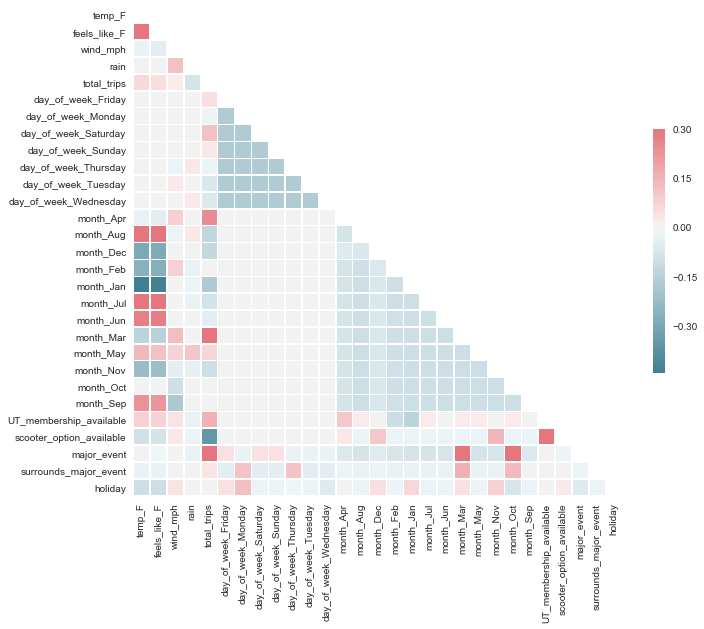

In [47]:
# Compute the correlation matrix
corr = weather_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

There is obvious collinearity between temp_F and feels_like_F. We will remove feels_like_F since it could have some collinearity with wind_mph too.

In [48]:
# Remove collinear features, redundant dummy features
X = weather_df.drop(['total_trips','date','feels_like_F','day_of_week_Monday', 'month_Jan'], axis=1) 
y = weather_df['total_trips']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=200)

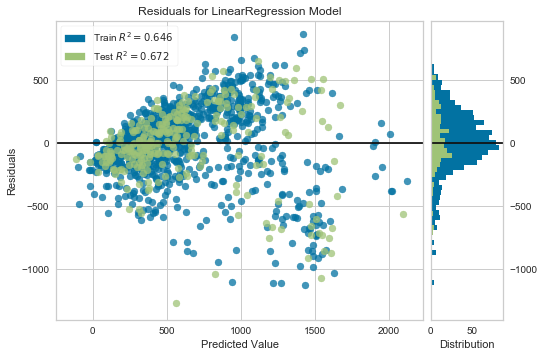

In [49]:
# Run linear regression

X = weather_df.drop(['total_trips','date'], axis=1)
y = weather_df['total_trips']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=200)

# Plot residuals with new variables added
regressor = LinearRegression() 
visualizer = ResidualsPlot(regressor)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

Our model is not perfect, but could be useful for predicting future demand, given a set of variables.